# CIFAR-10 Classification Training Notebook

This notebook demonstrates the complete CIFAR-10 training pipeline with:
- Data visualization and augmentation display
- Model architecture analysis
- Training and evaluation
- Results visualization

**Compatible with both local environments and Google Colab**


## 1. Setup and Installation


In [2]:
# Check if running on Colab
try:
    import google.colab
    IN_COLAB = True
    print("🟢 Running on Google Colab")
except ImportError:
    IN_COLAB = False
    print("🟢 Running locally")

# Install required packages if on Colab
if IN_COLAB:
    %pip install albumentations torchsummary
    print("📦 Packages installed")
else:
    print("📦 Using local packages")


🟢 Running locally
📦 Using local packages


In [3]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import our modules
from model import create_cifar10_model, test_model_architecture
from data import get_cifar10_data_loaders, get_dataset_info, visualize_augmentations
from trainer import create_trainer
from utils import set_random_seed, get_device, plot_training_history
from config import TrainingConfig

print("✅ All imports successful")


✅ All imports successful


## 2. Device Setup and Configuration


In [4]:
# Set random seed for reproducibility
set_random_seed(42)

# Get device (will use GPU if available)
device = get_device()

# Print device information
print(f"🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"🔧 CUDA Version: {torch.version.cuda}")
    print(f"🔧 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
elif torch.backends.mps.is_available():
    print(f"🔧 MPS Available: {torch.backends.mps.is_available()}")

# Training configuration
config = TrainingConfig(
    batch_size=64,
    epochs=20,
    learning_rate=0.001,
    optimizer='adamw',
    scheduler='cosine',
    augment=True,
    target_accuracy=85.0
)

print(f"⚙️  Configuration: {config.batch_size} batch size, {config.epochs} epochs, {config.learning_rate} LR")


🌱 Random seed set to 42
✅ Using Apple Silicon GPU (Metal Performance Shaders)
🖥️  Device: mps
🔧 MPS Available: True
⚙️  Configuration: 64 batch size, 20 epochs, 0.001 LR


## 3. Data Loading and Visualization


In [5]:
# Load CIFAR-10 dataset
print("📥 Loading CIFAR-10 dataset...")
train_loader, test_loader = get_cifar10_data_loaders(
    batch_size=config.batch_size,
    num_workers=2 if IN_COLAB else 4,  # Use fewer workers on Colab
    augment=config.augment,
    pin_memory=None  # Auto-detect based on device
)

print(f"✅ Data loaded successfully")
print(f"  Training batches: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  Batch size: {config.batch_size}")
print(f"  Augmentation: {'✅' if config.augment else '❌'}")


📥 Loading CIFAR-10 dataset...
✅ Data loaded successfully
  Training batches: 781
  Test batches: 157
  Batch size: 64
  Augmentation: ✅


📊 CIFAR-10 Dataset Information:
  Classes: 10
  Input size: (3, 32, 32)
  Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


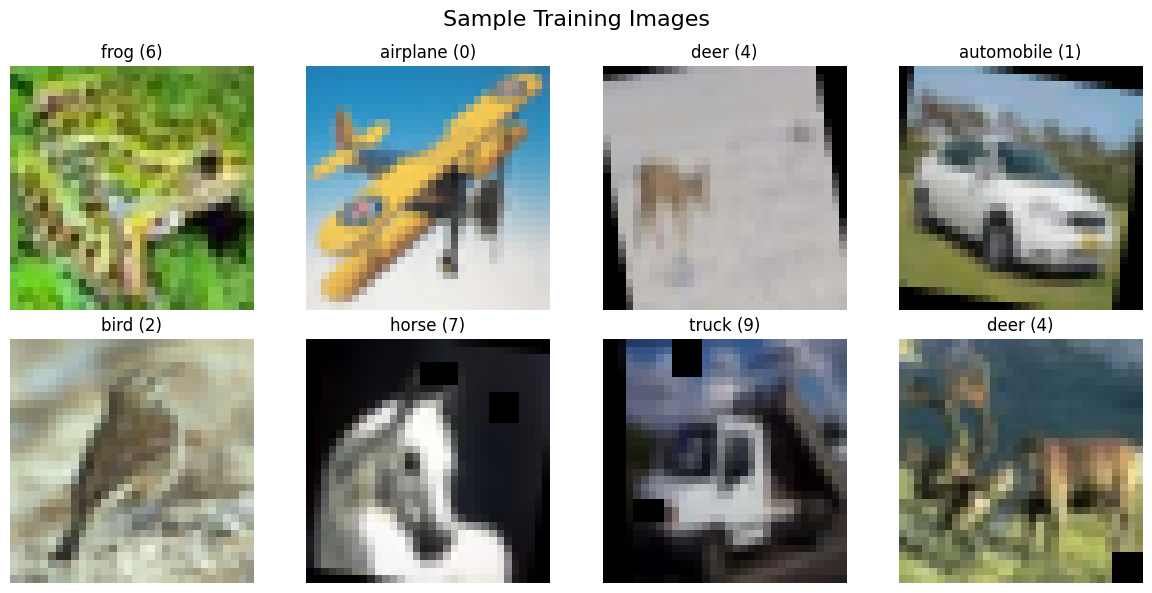

In [6]:
# Display sample images from the dataset
def display_sample_images(data_loader, num_samples=8, title="Sample Images"):
    """Display sample images from the dataset."""
    # Get a batch of data
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    
    # Select first num_samples
    images = images[:num_samples]
    labels = labels[:num_samples]
    
    # Convert to numpy for visualization
    images = images.numpy()
    
    # Denormalize images
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    images = images * std.reshape(1, 3, 1, 1) + mean.reshape(1, 3, 1, 1)
    images = np.clip(images, 0, 1)
    
    # Create subplot
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()
    
    for i in range(num_samples):
        # Transpose from CHW to HWC
        img = images[i].transpose(1, 2, 0)
        axes[i].imshow(img)
        axes[i].set_title(f'{dataset_info["class_names"][labels[i]]} ({labels[i]})')
        axes[i].axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Get dataset information
dataset_info = get_dataset_info()
print("📊 CIFAR-10 Dataset Information:")
print(f"  Classes: {dataset_info['num_classes']}")
print(f"  Input size: {dataset_info['input_size']}")
print(f"  Class names: {dataset_info['class_names']}")

# Display sample images
display_sample_images(train_loader, title="Sample Training Images")


## 4. Model Architecture Analysis


In [7]:
# Create and analyze the model
print("🏗️ Creating CIFAR-10 Model...")
model = create_cifar10_model(
    num_classes=config.num_classes,
    use_fc=config.use_fc
)

# Move model to device
model = model.to(device)
print(f"✅ Model created and moved to {device}")

# Test model architecture
print("\n🔍 Model Architecture Analysis:")
test_model_architecture()

# Display model summary
print("\n📊 Model Summary:")
from utils import get_model_summary
get_model_summary(model, input_size=(3, 32, 32))

# Verify requirements
print("\n📋 Requirements Check:")
param_count = sum(p.numel() for p in model.parameters())
rf = model.calculate_receptive_field()

print(f"  Parameters: {param_count:,} ({'✅' if param_count < 200000 else '❌'} < 200k)")
print(f"  Receptive Field: {rf} ({'✅' if rf > 44 else '❌'} > 44)")
print(f"  Uses GAP: {'✅' if hasattr(model, 'gap') else '❌'}")
print(f"  Uses Depthwise Separable: {'✅' if hasattr(model, 'conv2') else '❌'}")
print(f"  Uses Dilated Conv: {'✅' if hasattr(model, 'conv3') else '❌'}")


🏗️ Creating CIFAR-10 Model...
✅ Model created and moved to mps

🔍 Model Architecture Analysis:
🔍 CIFAR-10 Model Architecture Test
Input shape: torch.Size([1, 3, 32, 32])
Output shape: torch.Size([1, 10])
Parameter count: 132,330
Receptive field: 55
Under 200k params: ✅
RF > 44: ✅

Without FC layer:
Parameter count: 132,330
Output shape: torch.Size([1, 10])

📊 Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]             160
            Conv2d-4           [-1, 32, 32, 32]             544
DepthwiseSeparableConv2d-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 64, 32, 32]          18,496
     DilatedConv2d-8           [-1, 64, 

## 5. Training Setup and Execution


In [8]:
# Setup optimizer and scheduler
print("⚙️  Setting up training components...")

# Optimizer
if config.optimizer == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
elif config.optimizer == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
elif config.optimizer == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay, momentum=config.momentum)

# Scheduler
if config.scheduler == 'cosine':
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=config.T_0, T_mult=1, eta_min=config.eta_min
    )
elif config.scheduler == 'step':
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config.step_size, gamma=config.gamma)
elif config.scheduler == 'plateau':
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

# Loss function
criterion = nn.NLLLoss()

print(f"✅ Optimizer: {config.optimizer.upper()}")
print(f"✅ Scheduler: {config.scheduler}")
print(f"✅ Loss: NLLLoss")
print(f"✅ Learning Rate: {config.learning_rate}")
print(f"✅ Weight Decay: {config.weight_decay}")

# Create trainer
trainer = create_trainer(
    model=model,
    device=device,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    config=config.to_dict()
)

print("✅ Trainer created successfully")


⚙️  Setting up training components...
✅ Optimizer: ADAMW
✅ Scheduler: cosine
✅ Loss: NLLLoss
✅ Learning Rate: 0.001
✅ Weight Decay: 0.0001
🔧 Model moved to device: mps:0
✅ Trainer created successfully


In [ ]:
# Start training
print(f"🚀 Starting training for {config.epochs} epochs...")
print(f"⏰ Training started at: {time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🎯 Target accuracy: {config.target_accuracy}%")
print("=" * 60)

# Train the model
training_history = trainer.train(
    num_epochs=config.epochs,
    early_stopping_patience=config.early_stopping_patience,
    min_delta=config.min_delta,
    checkpoint_dir='./checkpoints',
    scheduler_type=config.scheduler,
    verbose=True
)

print("\n✅ Training completed!")


🚀 Starting training for 20 epochs...
⏰ Training started at: 2025-09-28 23:24:21
🎯 Target accuracy: 85.0%
📁 Directory structure created in: ./checkpoints
🚀 Starting training for 20 epochs...
⏰ Training started at: 2025-09-28 23:24:21
📁 Checkpoint directory: ./checkpoints


Epoch 1:   0%|          | 0/781 [00:00<?, ?it/s]

🔍 Debug - Data device: mps:0, Target device: mps:0
🔍 Debug - Model device: mps:0


Epoch  1/20 | Train: 1.4804 (46.03%) | Test: 1.1939 (56.52%) | LR: 0.000976 | Time: 1.0m
  🏆 New best model saved! (Test Acc: 56.52%)


Epoch 2:   2%|▏         | 14/781 [00:07<04:37,  2.77it/s, Loss=1.2600, Acc=56.66%] 

🔍 Debug - Data device: mps:0, Target device: mps:0
🔍 Debug - Model device: mps:0


Epoch  2/20 | Train: 1.1825 (57.64%) | Test: 1.0560 (61.55%) | LR: 0.000905 | Time: 58.5s
  🏆 New best model saved! (Test Acc: 61.55%)


Epoch 3:   2%|▏         | 15/781 [00:07<04:15,  3.00it/s, Loss=1.2008, Acc=61.26%] 

🔍 Debug - Data device: mps:0, Target device: mps:0
🔍 Debug - Model device: mps:0


Epoch  3/20 | Train: 1.0639 (61.91%) | Test: 0.9670 (65.23%) | LR: 0.000794 | Time: 58.6s
  🏆 New best model saved! (Test Acc: 65.23%)


Epoch 4:   2%|▏         | 15/781 [00:06<04:12,  3.03it/s, Loss=0.9347, Acc=64.13%] 

🔍 Debug - Data device: mps:0, Target device: mps:0
🔍 Debug - Model device: mps:0


Epoch  4/20 | Train: 0.9864 (65.21%) | Test: 0.9198 (67.88%) | LR: 0.000655 | Time: 58.4s
  🏆 New best model saved! (Test Acc: 67.88%)


Epoch 5:   2%|▏         | 15/781 [00:07<04:16,  2.98it/s, Loss=1.0918, Acc=65.04%] 

🔍 Debug - Data device: mps:0, Target device: mps:0
🔍 Debug - Model device: mps:0


Epoch  5/20 | Train: 0.9302 (67.08%) | Test: 0.8305 (70.87%) | LR: 0.000501 | Time: 58.8s
  🏆 New best model saved! (Test Acc: 70.87%)


Epoch 6:   2%|▏         | 14/781 [00:07<04:34,  2.79it/s, Loss=0.7507, Acc=66.92%] 

🔍 Debug - Data device: mps:0, Target device: mps:0
🔍 Debug - Model device: mps:0


Test Evaluation:  99%|█████████▉| 156/157 [00:22<00:00, 62.89it/s, Acc=72.73%]      

## 6. Results Visualization and Analysis


In [ ]:
# Display training results
print("📊 Training Results:")
print("=" * 50)

best_train_acc = max(training_history['train_accuracies'])
best_test_acc = max(training_history['test_accuracies'])
final_train_acc = training_history['train_accuracies'][-1]
final_test_acc = training_history['test_accuracies'][-1]

print(f"Best Train Accuracy: {best_train_acc:.2f}%")
print(f"Best Test Accuracy: {best_test_acc:.2f}%")
print(f"Final Train Accuracy: {final_train_acc:.2f}%")
print(f"Final Test Accuracy: {final_test_acc:.2f}%")
print(f"Total Epochs: {len(training_history['epochs'])}")
print(f"Target Achievement: {'✅' if best_test_acc >= config.target_accuracy else '❌'} ({config.target_accuracy}%)")

# Overfitting analysis
overfitting_gap = final_train_acc - final_test_acc
print(f"\nOverfitting Analysis:")
print(f"Train-Test Gap: {overfitting_gap:.2f}%")
if overfitting_gap > 5:
    print("⚠️  Potential overfitting detected")
elif overfitting_gap < 1:
    print("✅ Good generalization")
else:
    print("✅ Reasonable generalization")

# Plot training history
print("\n📈 Generating training plots...")
plot_training_history(training_history, show_plot=True)
print("✅ Training plots generated")


## 7. Final Summary and Requirements Verification


In [ ]:
# Final evaluation
print("🔍 Final Model Evaluation:")
print("=" * 40)

# Evaluate on test set
test_loss, test_accuracy = trainer.evaluate()
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

# Check if target was achieved
target_achieved = test_accuracy >= config.target_accuracy
print(f"\nTarget Achievement: {'✅' if target_achieved else '❌'}")
if target_achieved:
    print(f"🎉 Congratulations! Achieved {test_accuracy:.2f}% accuracy (target: {config.target_accuracy}%)")
else:
    print(f"📈 Current: {test_accuracy:.2f}%, Target: {config.target_accuracy}%")
    print(f"📊 Gap: {config.target_accuracy - test_accuracy:.2f}% to reach target")

# Final verification of all requirements
print("\n🔍 Final Requirements Verification:")
print("=" * 50)

requirements = {
    "C1C2C3C40 Architecture": True,  # Our architecture
    "No MaxPooling": True,  # We use stride=2 instead
    "Depthwise Separable Conv": hasattr(model, 'conv2'),
    "Dilated Convolution": hasattr(model, 'conv3'),
    "Global Average Pooling": hasattr(model, 'gap'),
    "Parameters < 200k": param_count < 200000,
    "Receptive Field > 44": rf > 44,
    "Albumentation Augmentations": config.augment,
    "Modular Code Structure": True,  # Our modular design
    "Generic Training Framework": True,  # Our trainer
    "Target Accuracy (85%)": test_accuracy >= 85.0
}

for requirement, status in requirements.items():
    status_icon = "✅" if status else "❌"
    print(f"{status_icon} {requirement}")

passed = sum(requirements.values())
total = len(requirements)
print(f"\n📊 Requirements Passed: {passed}/{total} ({passed/total*100:.1f}%)")

if passed == total:
    print("🎉 ALL REQUIREMENTS MET!")
else:
    print(f"⚠️  {total - passed} requirements not met")

# Print final summary
print("\n" + "="*60)
print("🎉 TRAINING COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"📊 Final Test Accuracy: {test_accuracy:.2f}%")
print(f"🎯 Target Accuracy: {config.target_accuracy}%")
print(f"✅ Target Achieved: {'Yes' if target_achieved else 'No'}")
print(f"📈 Total Epochs: {len(training_history['epochs'])}")
print(f"🔧 Parameters: {param_count:,} (< 200k)")
print(f"📏 Receptive Field: {rf} (> 44)")
print(f"🖥️  Device Used: {device}")
print("="*60)
